In [3]:
# All needed imports

import pickle
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [47]:
# 1. Camera Calibration

def extract_image_and_object_points(image_dir, chessboard_x = 9, chessboard_y = 6):
    """
    Extracts the image points and onbject points from the given image_dir
    
    Args:
        image_dir:    The path glob which can be used to find the images
        chessboard_x: The chessboard corners in the x axis
        chessboard_y: The chessboard corners in the y axis
        
    Returns:
        The pickle file that conatin both of these data.
    """
    objp = np.zeros((chessboard_x*chessboard_y,3), np.float32)
    objp[:,:2] = np.mgrid[0:chessboard_x, 0:chessboard_y].T.reshape(-1,2)
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    images = glob.glob(image_dir)
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (chessboard_x,chessboard_y), None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    return imgpoints,objpoints

def get_image_and_distortion_matrix(image_dir, test_image, chessboard_x = 9, chessboard_y = 6):
    """
    Returns the image matrix and ditortion matrix for the given image, image points and object points
    
    Args:
        image_dir:    The path glob which can be used to find the images
        test_image:   The array like image or PIL image
        chessboard_x: The chessboard corners in the x axis
        chessboard_y: The chessboard corners in the y axis
        
    Returns:
        The pickel file that contains the distorations
    """
    # Get the image and object points from the given image by the corners
    imgpoints, objpoints = extract_image_and_object_points(image_dir)
    img_size = (test_image.shape[1], test_image.shape[0])
    # Get the camera matrix and ditortion with the help of cv2
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    dist_pickle['imgpoints'] = imgpoints
    dist_pickle['objpoints'] = objpoints
    # Save everything as pickle
    pickle.dump( dist_pickle, open( "calibrate_dist_pickle.p", "wb" ) )


In [74]:
img = cv2.imread("camera_cal/calibration14.jpg")
get_image_and_distortion_matrix('camera_cal/*.jpg', img)

In [75]:
# 2. Apply the calibration to remove distoration on the given raw images

def undistort_images(img, chessboard_x = 9, chessboard_y = 6, calibrate_pickle = 'calibrate_dist_pickle.p'):
    """
    Undistort the given image with the help of calibrate pickel created before.
    
    Args:
        img: The array like image or PIL image
        calibrate_pickle: The path to the pickle file that should contain the image matrix and distorations
    
    Returns:
        Returns the undistorted image.
    """
    dist_pickle = pickle.load( open( calibrate_pickle, "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    grayscale = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(undist, (chessboard_x, chessboard_y), None)
    M = None
    warped = np.copy(img) 
    if ret == True:
        cv2.drawChessboardCorners(undist, (chessboard_x, chessboard_y), corners, ret)
        image_size =  undist.shape[1::-1]
        src_points = np.float32([corners[0],corners[chessboard_x-1],corners[-1],corners[-chessboard_x]])
        offset = 50
        dst_points = np.float32([
            [offset, offset], 
            [image_size[0] - offset, offset], 
            [image_size[0] - offset, image_size[1]- offset], 
            [offset, image_size[1]- offset]])
        M = cv2.getPerspectiveTransform(src_points,dst_points)
        warped = cv2.warpPerspective(undist, M, image_size, flags=cv2.INTER_LINEAR) 
    return warped, M

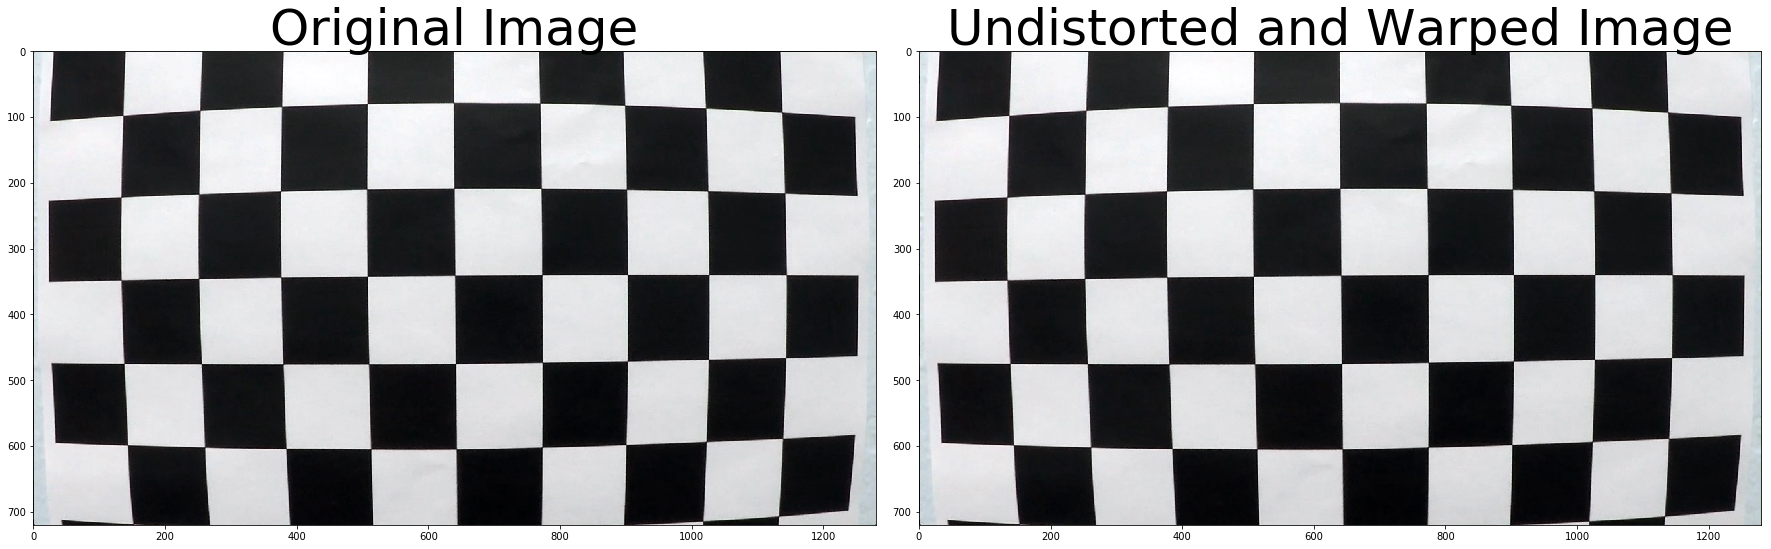

In [77]:
img = cv2.imread("camera_cal/calibration1.jpg")
top_down, perspective_M = undistort_images(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)